# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import soundfile
import os, glob, pickle
import random
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Preprocessing the dataset

In [ ]:
#Connecting to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading Ravdess Dataset
paths=[]
labels=[]
for dirname,_,filenames in os.walk('/content/drive/MyDrive/SER_Dataset/SER_dataset/Ravdess/audio_speech_actors_01-24'):
  for filename in filenames:
    if(filename.split('-')[2]=='02'):
      continue
    paths.append(os.path.join(dirname,filename))
    label = filename.split('-')[2]
    if(label=='01'):
      label='neutral'
    elif(label=='02'):
      continue
    elif(label=='03'):
      label='happy'
    elif(label=='04'):
      label='sad'
    elif(label=='05'):
      label='angry'
    elif(label=='06'):
      label='fear'
    elif(label=='07'):
      label='disgust'
    elif(label=='08'):
      label='ps'
    labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
#Loading Tess Dataset
for dirname,_,filenames in os.walk('/content/drive/MyDrive/SER_Dataset/SER_dataset/Tess'):
  for filename in filenames:
    paths.append(os.path.join(dirname,filename))
    label = filename.split('_')[-1]
    label = label.split('.')[0]
    labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
#Loading Savee Dataset
for dirname,_,filenames in os.walk('/content/drive/MyDrive/SER_Dataset/SER_dataset/Savee'):
  for filename in filenames:
    paths.append(os.path.join(dirname,filename))
    label = filename.split('_')[1]

    if(label[0]=='n'):
      label='neutral'
    elif(label[0]=='h'):
      label='happy'
    elif(label[1]=='a'):
      label='sad'
    elif(label[0]=='a'):
      label='angry'
    elif(label[0]=='f'):
      label='fear'
    elif(label[0]=='d'):
      label='disgust'
    elif(label[1]=='u'):
      label='ps'
    labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
len(paths)

4535

In [ ]:
len(labels)

4535

In [ ]:
#Creating the DataFrame
df = pd.DataFrame()
df['speech']=paths
df['label']=labels
df.head()

,speech,label
0,/content/drive/MyDrive/SER_Dataset/SER_dataset...,neutral
1,/content/drive/MyDrive/SER_Dataset/SER_dataset...,neutral
2,/content/drive/MyDrive/SER_Dataset/SER_dataset...,neutral
3,/content/drive/MyDrive/SER_Dataset/SER_dataset...,sad
4,/content/drive/MyDrive/SER_Dataset/SER_dataset...,happy


In [ ]:
df['label'].value_counts()

disgust    658
ps         653
sad        652
happy      652
angry      652
fear       652
neutral    616
Name: label, dtype: int64

# Displaying Waveplots and Spectograms

In [ ]:
#Creating functions for plotting waveplot and Spectogram
def waveplot(data,sr,emotion):
  plt.figure(figsize=(14,3))
  plt.title(title,size=20)
  librosa.display.waveshow(data,sr=sr)
  plt.show()
def spectogram(data,sr,emotion):
  x = librosa.stft(data)
  xdb = librosa.amplitude_to_db(abs(x))
  plt.figure(figsize=(15,3))
  plt.title(title,size=20)
  librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()


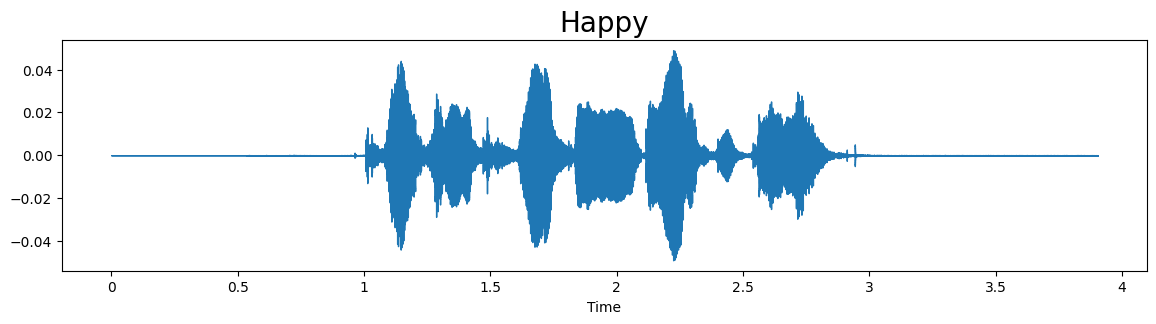

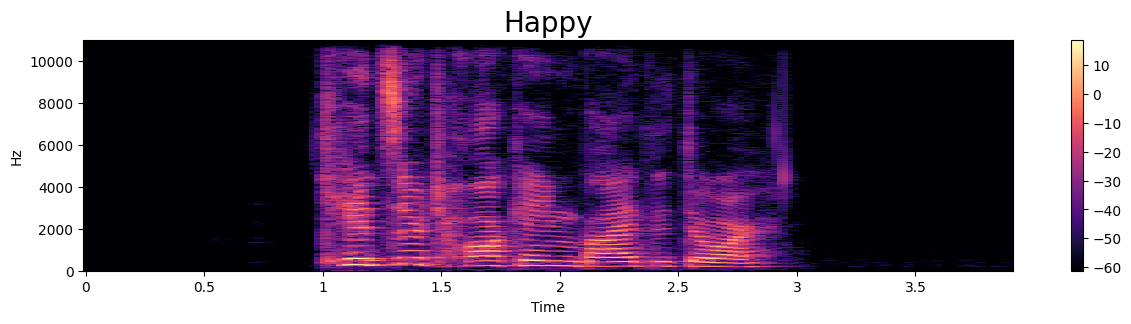

In [ ]:
#Example of plotting graphs for a fear
emotion = 'happy'
title='Happy'
path=np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

#Data Augmentation

In [ ]:
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data+noise_amp*np.random.normal(size=data.shape[0])
  return data

def stretch(data):
  return librosa.effects.time_stretch(data,rate=0.8)

def shift(data):
  shift_range = int(np.random.uniform(low=-5,high=5)*1000)
  return np.roll(data,shift_range)

def pitch(data,sampling_rate):
  return librosa.effects.pitch_shift(data,sr=sampling_rate,n_steps=0.7)

# Showing Data Aurgumentation for one sample
emotion='happy'
path=np.array(df['speech'][df['label']==emotion])[1]
data, sr = librosa.load(path)

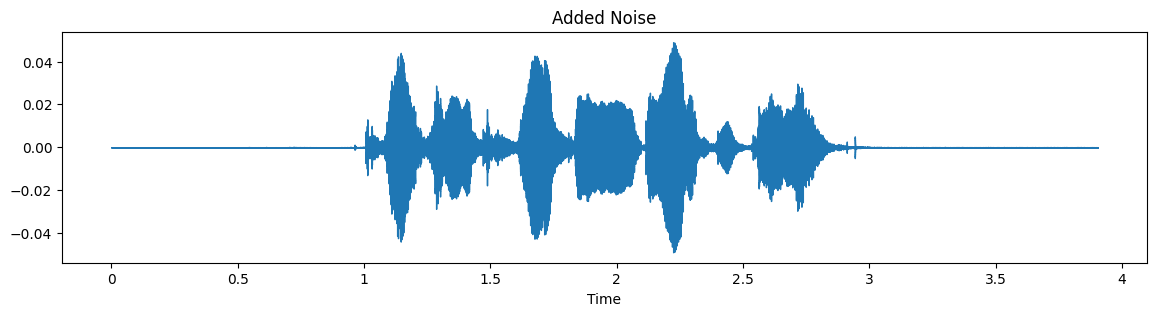

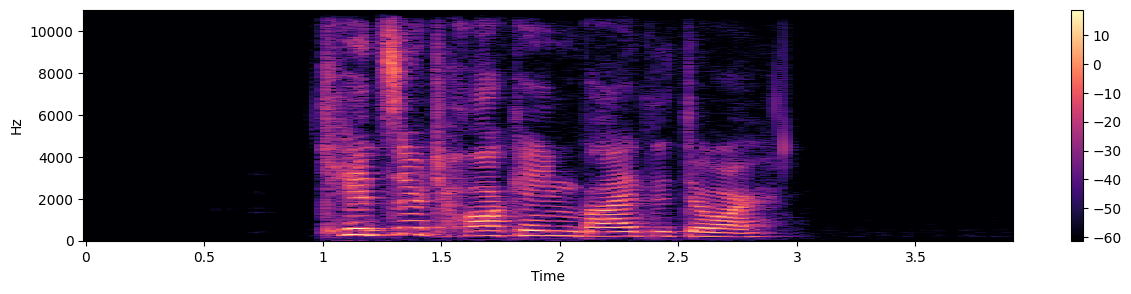

In [ ]:
# Noise Injeection
x=noise(data)
plt.figure(figsize=(14,3))
plt.title('Added Noise')
title=''
librosa.display.waveshow(y=x,sr=sr)
spectogram(x,sr,emotion)
Audio(x,rate=sampling_rate)

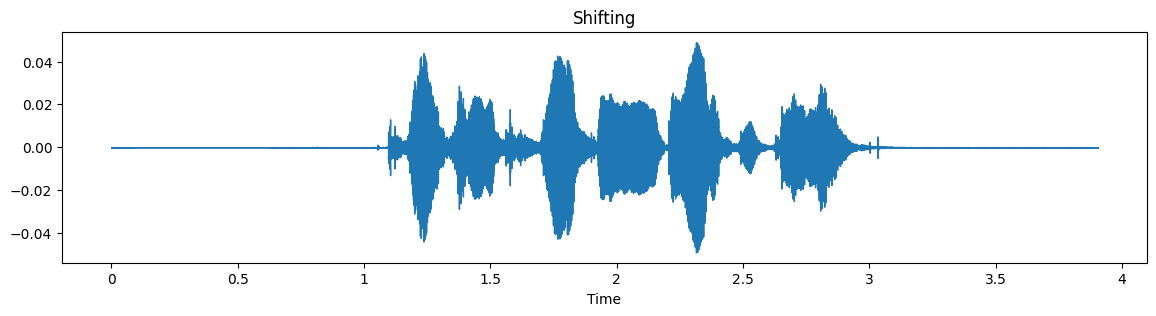

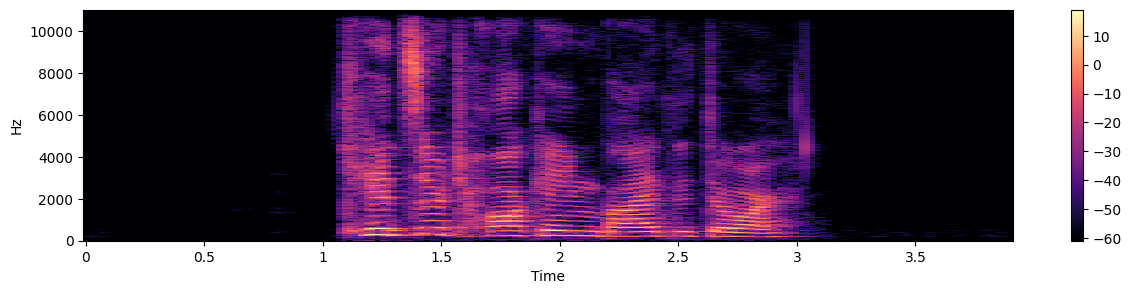

In [ ]:
# Shifting
x = shift(data)
plt.figure(figsize=(14,3))
plt.title('Shifting')
title=''
librosa.display.waveshow(y=x, sr=sr)
spectogram(x,sr,emotion)
Audio(x, rate=sampling_rate)

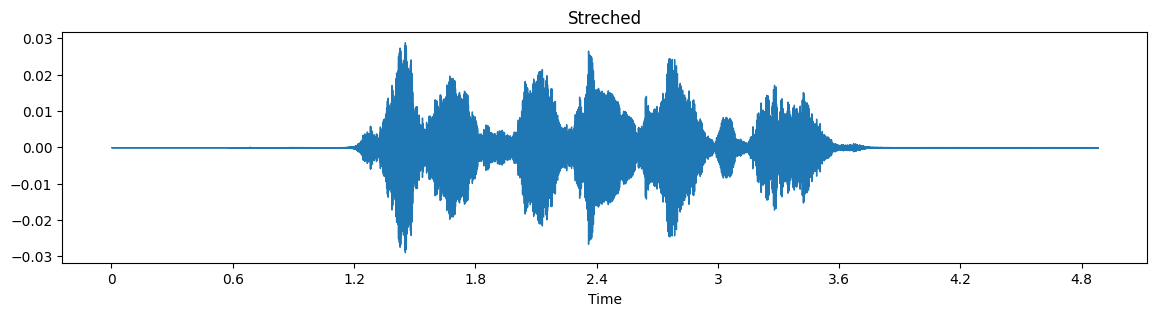

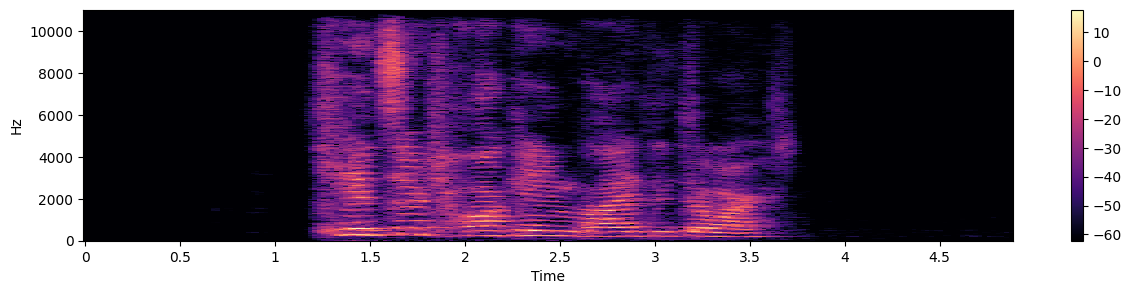

In [ ]:
# Streching
x = stretch(data)
plt.figure(figsize=(14,3))
plt.title('Streched')
title=''
librosa.display.waveshow(y=x,sr=sr)
spectogram(x,sr,emotion)
Audio(x,rate=sampling_rate)

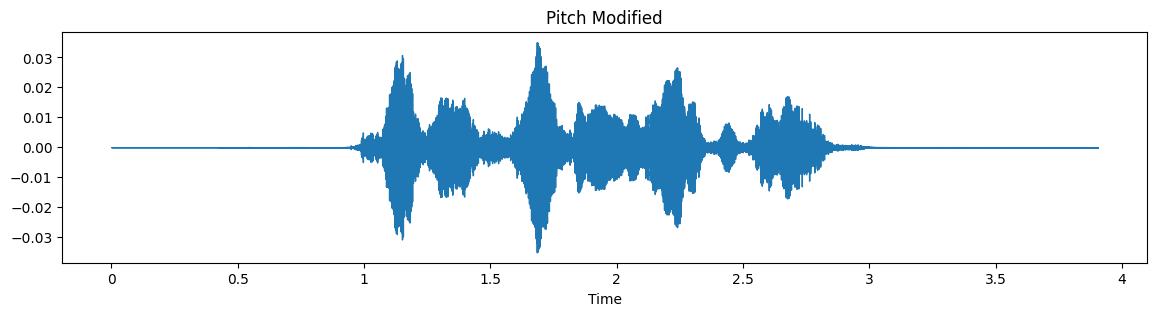

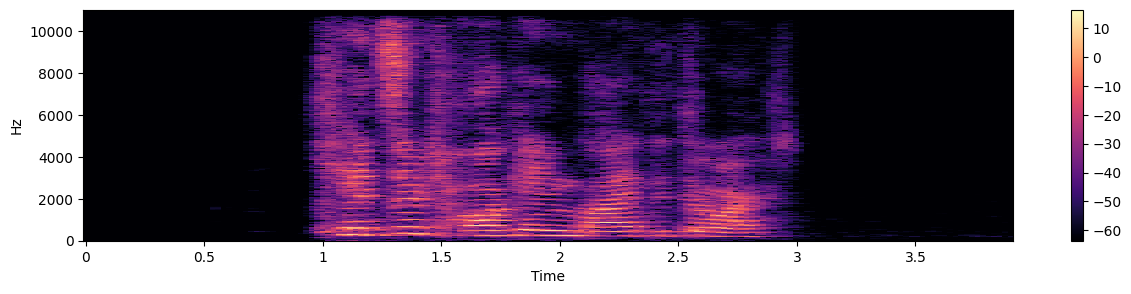

In [ ]:
# Pitch
x = pitch(data,sr)
plt.figure(figsize=(14,3))
plt.title('Pitch Modified')
title=''
librosa.display.waveshow(y=x, sr=sr)
spectogram(x,sr,emotion)
Audio(x, rate=sampling_rate)

#Feature Extraction

In [ ]:
def extract_features(y):
  result=np.array([])
  #mfcc
  Mfcc = np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)
  result=np.hstack((result,Mfcc))
  #chroma
  stft=np.abs(librosa.stft(y))
  Chroma=np.mean(librosa.feature.chroma_stft(S=stft,sr=sr).T,axis=0)
  result = np.hstack((result,Chroma))
  #mel
  Mel=np.mean(librosa.feature.melspectrogram(y=y,sr=sr).T,axis=0)
  result=np.hstack((result,Mel))
  #zcr
  Zcr =np.mean(librosa.feature.zero_crossing_rate(y=y).T,axis=0)
  result=np.hstack((result,Zcr))
  #rms
  Rms = np.mean(librosa.feature.rms(y=y).T,axis=0)
  result=np.hstack((result,Rms))
  return result

In [ ]:
def get_features(filename):
  y,sr = librosa.load(filename,duration=3,offset=0.5)
  # Without augmentation
  res1= extract_features(y)
  result = np.array(res1)

  # Data with noise
  noise_data = noise(y)
  res2=extract_features(noise_data)
  result = np.vstack((result,res2))

  # Data with Streching and Pitching
  data = stretch(y)
  ddata = pitch(data,sr)
  res3 = extract_features(ddata)
  result = np.vstack((result,res3))

  return result

In [ ]:
get_features(df['speech'][0])

array([[-6.56365845e+02,  5.33853607e+01, -9.12110519e+00,
         1.05633342e+00, -9.85986519e+00, -9.44822979e+00,
        -1.40470610e+01, -1.54553871e+01, -1.04799995e+01,
        -8.20174026e+00, -1.05536137e+01, -3.94806290e+00,
        -7.55606508e+00, -6.50345755e+00, -3.50893879e+00,
        -7.73866892e+00, -5.36868191e+00, -5.79308987e+00,
        -7.53292513e+00, -5.40056467e+00, -6.16821909e+00,
        -5.24304724e+00, -4.80135107e+00, -3.22227788e+00,
        -2.86873007e+00,  4.97119188e-01,  6.57582700e-01,
         2.61321902e+00,  2.10879564e+00,  5.13847971e+00,
         5.22174454e+00,  8.23751450e+00,  8.43279743e+00,
         7.49837208e+00,  5.05258989e+00,  2.66102099e+00,
         4.62617248e-01,  1.20444584e+00, -4.16647971e-01,
        -2.43451633e-02,  6.17651999e-01,  5.74763894e-01,
         5.50299406e-01,  5.61379075e-01,  5.23146689e-01,
         4.61876482e-01,  4.89006996e-01,  5.63954055e-01,
         6.32764459e-01,  6.74031734e-01,  6.59276605e-0

In [ ]:
X,Y =[],[]
for i in range(len(paths)):
  feature = get_features(df['speech'][i])
  for ele in feature:
    X.append(ele)
    Y.append(df['label'][i])

In [ ]:
# Getting the data into csv
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,labels
0,-656.365845,53.385361,-9.121105,1.056333,-9.859865,-9.448230,-14.047061,-15.455387,-10.480000,-8.201740,...,0.000152,0.000113,0.000048,0.000027,0.000064,0.000052,0.000004,0.284229,0.003134,neutral
1,-495.095781,24.720615,2.563779,-0.948634,-4.839763,-5.963253,-8.266570,-9.735562,-7.297049,-5.120921,...,0.000171,0.000133,0.000066,0.000044,0.000081,0.000071,0.000023,0.307523,0.003356,neutral
2,-648.325989,52.648201,-8.608706,4.927527,-10.574008,-6.869434,-14.353024,-13.974558,-6.995541,-6.648952,...,0.000053,0.000044,0.000034,0.000035,0.000029,0.000015,0.000001,0.273246,0.003536,neutral
3,-466.133593,21.622969,3.034121,-0.658391,-6.036315,-4.590865,-9.388160,-9.660531,-5.754724,-4.373660,...,0.000088,0.000082,0.000067,0.000068,0.000063,0.000050,0.000036,0.306430,0.003857,neutral
4,-651.583679,49.523674,-15.289292,2.101128,-10.083641,-11.913666,-12.493160,-15.879214,-9.704226,-6.782935,...,0.000110,0.000151,0.000061,0.000026,0.000064,0.000029,0.000001,0.345068,0.002839,neutral


In [ ]:
# Preparing the Dataset
X = Features.iloc[:,:-1].values
Y = Features.iloc[:,-1].values

In [ ]:
#Encoding the dependent variable
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# Splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6802, 182), (6802, 7), (2268, 182), (2268, 7))

In [ ]:
# Scaling the data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6802, 182), (6802, 7), (2268, 182), (2268, 7))

# Training the Dataset







In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 182, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 91, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 91, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 46, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 23, 128)          0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=256, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
27/27 [==============================] - 62s 2s/step - loss: 1.7243 - accuracy: 0.3105 - val_loss: 1.3475 - val_accuracy: 0.4978 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 59s 2s/step - loss: 1.3246 - accuracy: 0.5087 - val_loss: 1.0556 - val_accuracy: 0.6371 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 61s 2s/step - loss: 1.0988 - accuracy: 0.5907 - val_loss: 0.9379 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 60s 2s/step - loss: 0.9780 - accuracy: 0.6410 - val_loss: 0.8450 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 60s 2s/step - loss: 0.8965 - accuracy: 0.6777 - val_loss: 0.7780 - val_accuracy: 0.7227 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 58s 2s/step - loss: 0.8312 - accuracy: 0.6942 - val_loss: 0.7350 - val_accuracy: 0.7315 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 61s 2s/step - loss: 0.7859 - a

71/71 [==============================] - 11s 159ms/step - loss: 0.4596 - accuracy: 0.8496
Accuracy of our model on test data :  84.96472835540771 %


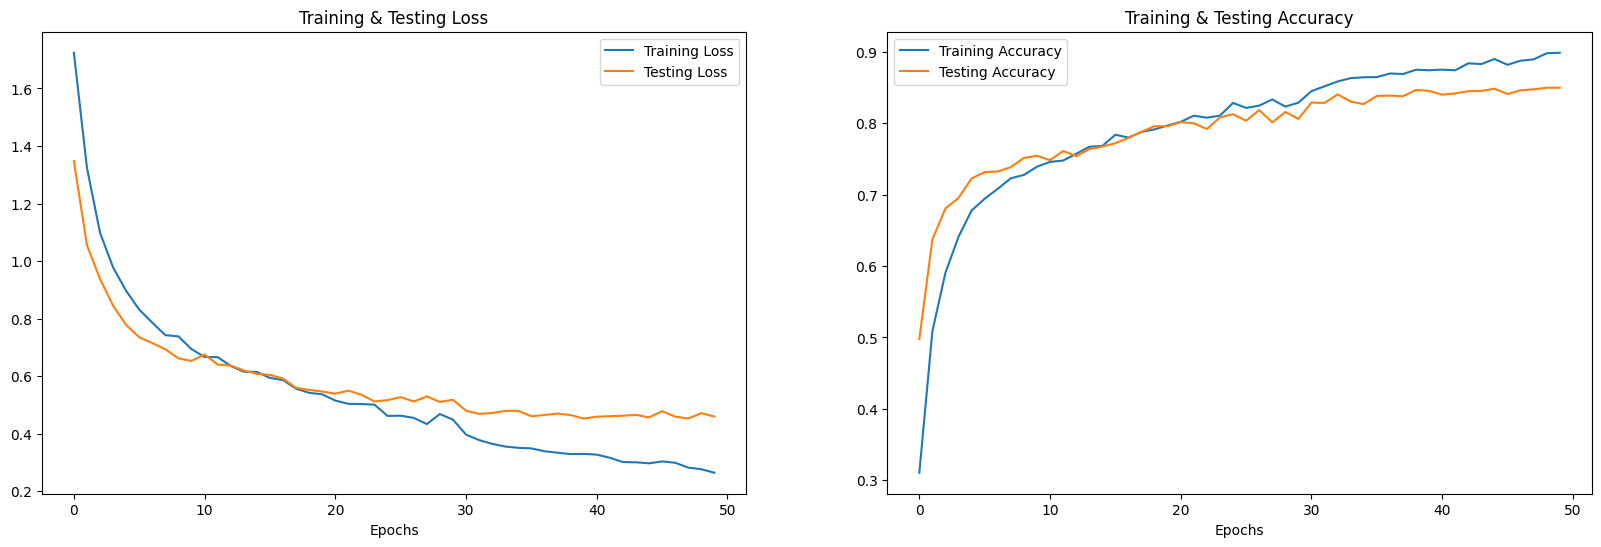

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

71/71 [==============================] - 4s 53ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,neutral,neutral
2,angry,angry
3,fear,fear
4,ps,ps
5,happy,happy
6,neutral,neutral
7,angry,happy
8,disgust,disgust
9,ps,ps


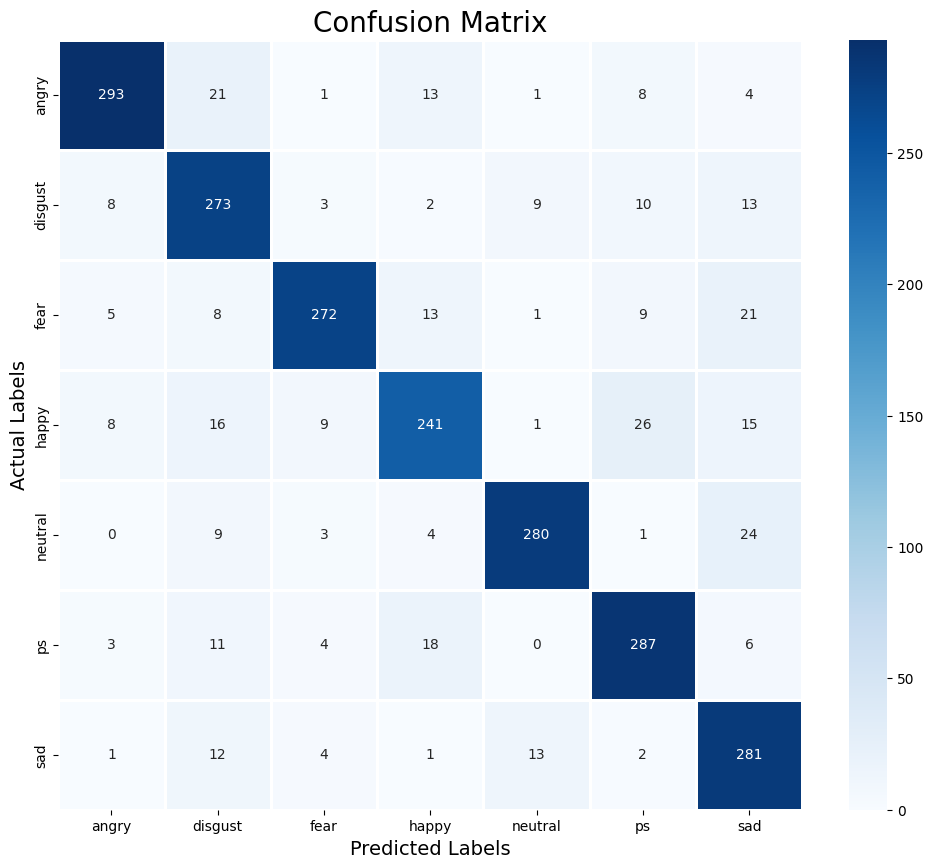

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.86      0.89       341
     disgust       0.78      0.86      0.82       318
        fear       0.92      0.83      0.87       329
       happy       0.83      0.76      0.79       316
     neutral       0.92      0.87      0.89       321
          ps       0.84      0.87      0.85       329
         sad       0.77      0.89      0.83       314

    accuracy                           0.85      2268
   macro avg       0.85      0.85      0.85      2268
weighted avg       0.85      0.85      0.85      2268

